## Run a basic eqtl analysis
This will be something to compare the PC results to

do with and without residualized expression 

In [1]:
import pandas as pd
import torch
import tensorqtl
from tensorqtl import pgen, cis, trans, post, genotypeio
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

tissue_id = 'Whole_Blood'
chr_id = '21'
e_out_prefix=f'/home/klawren/oak/pcqtl/output/test/{tissue_id}/{tissue_id}'

### load in data

In [40]:
# define paths to data

subsample_num =75

plink_prefix_path = '/home/klawren/oak/pcqtls/data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'
pc_bed = f'/home/klawren/oak/pcqtls/output/subsampling_constant_clusters/{subsample_num}/pcs/{tissue_id}.pcs.bed'
covariates_file = f'/home/klawren/oak/pcqtls/data/processed/subsampling/{subsample_num}/covariates/{tissue_id}.v8.covariates.txt'

# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(pc_bed)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

In [3]:
# PLINK reader for genotypes
pgr = genotypeio.PlinkReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.bim.set_index('snp')[['chrom', 'pos']]

Mapping files: 100%|██████████████████████████████| 3/3 [00:21<00:00,  7.04s/it]


# subsampling
find a way to subset the cis results so I only map cis independent with the pc1 phenotypes

In [41]:
cis_output = f'/home/klawren/oak/pcqtls/output/subsampling_constant_clusters/{subsample_num}/pcqtl/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl.txt.gz'

In [42]:
# load in cis results
cis_df = pd.read_csv(cis_output, sep='\t', index_col=0)
cis_df_pc1 = cis_df.copy()
cis_df_pc1['qval_old'] = cis_df_pc1['qval']
cis_df_pc1 = cis_df_pc1[cis_df_pc1.index.str.contains('pc1')]

# get qvalues for just the pc1s subsample
tensorqtl.calculate_qvalues(cis_df_pc1, qvalue_lambda=0.85)

Computing q-values
  * Number of phenotypes tested: 886
  * Correlation between Beta-approximated and empirical p-values: 0.9998
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.28
  * QTL phenotypes @ FDR 0.05: 0


Text(0.5, 0, 'qval all pcs')

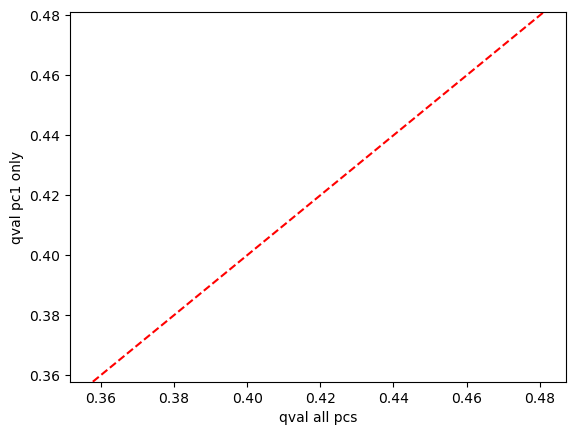

In [43]:
# plot q values
ax = sns.scatterplot(cis_df_pc1, x='qval_old', y='qval')
axlim = ax.get_xlim()
ax.set_ylim(axlim)
ax.plot(axlim, axlim, color='red', linestyle='--')
ax.set_ylabel('qval pc1 only')
ax.set_xlabel('qval all pcs')


In [31]:
cis_df['qval_old'] = cis_df['qval']
tensorqtl.calculate_qvalues(cis_df, qvalue_lambda=0.85)

Computing q-values
  * Number of phenotypes tested: 1977
  * Correlation between Beta-approximated and empirical p-values: 0.9999
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.28
  * QTL phenotypes @ FDR 0.05: 75
  * min p-value threshold @ FDR 0.05: 0.00255851


Text(0.5, 0, 'qval old')

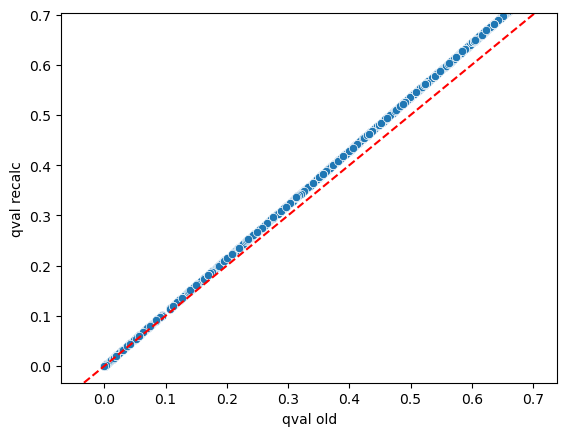

In [32]:
ax = sns.scatterplot(cis_df, x='qval_old', y='qval')

# plot q values
axlim = ax.get_xlim()
ax.set_ylim(axlim)
ax.plot(axlim, axlim, color='red', linestyle='--')
ax.set_ylabel('qval recalc')
ax.set_xlabel('qval old')


In [34]:
indep_df_pc1 = cis.map_independent(genotype_df, variant_df, cis_df,
                               phenotype_df, phenotype_pos_df, covariates_df, maf_threshold = .01)

cis-QTL mapping: conditionally independent variants
  * 100 samples
  * 75/1977 significant phenotypes
  * 68 covariates
  * 10770860 variants
  * applying in-sample 0.01 MAF filter
  * cis-window: ±1,000,000
  * checking phenotypes: 75/75
  * computing independent QTLs
    processing phenotype 75/75
  Time elapsed: 0.76 min
done.


In [37]:
indep_df_pc1

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank
0,ENSG00000011021.21_ENSG00000177000.10_pc1,7528,1.02539,836.356018,25.942499,2.309540e-07,chr1_11775398_T_G_b38,-31522,-31733,25,28,0.140,2.562980e-08,0.251938,0.033759,0.0002,1.537490e-04,1
1,ENSG00000083444.16_ENSG00000116685.15_ENSG0000...,7956,1.02453,916.125000,26.494600,3.569540e-07,chr1_12008884_T_C_b38,82456,-10582,60,70,0.650,5.881850e-08,0.227727,0.031840,0.0004,2.657090e-04,1
2,ENSG00000183386.9_ENSG00000183431.11_pc1,6660,1.01822,815.814026,26.199400,5.989100e-07,chr1_37957563_C_A_b38,-33358,-48043,27,30,0.150,8.928150e-08,-0.249172,0.035608,0.0003,4.218170e-04,1
3,ENSG00000117480.15_ENSG00000117481.10_pc1,5821,1.00798,360.489014,25.926001,1.515300e-06,chr1_46340570_G_T_b38,393,-53695,44,49,0.245,2.224380e-07,-0.263364,0.039529,0.0005,5.125790e-04,1
4,ENSG00000160781.15_ENSG00000163472.18_ENSG0000...,5525,1.05451,500.667999,25.673800,1.027350e-09,chr1_156274030_C_T_b38,25913,-21659,77,97,0.515,3.906530e-11,0.262378,0.026061,0.0001,2.280810e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,ENSG00000106772.17_ENSG00000187210.12_pc1,9842,1.05721,1247.880005,26.118700,1.079060e-10,chr9_76713488_TG_T_b38,293638,-192599,34,38,0.190,4.332870e-12,0.232538,0.021060,0.0001,5.311140e-08,1
71,ENSG00000106804.7_ENSG00000119397.16_pc1,5765,1.01279,492.455994,26.125799,5.121330e-06,chr9_121057467_A_C_b38,7191,-17396,59,76,0.380,9.992820e-07,-0.184267,0.030112,0.0022,2.320560e-03,1
72,ENSG00000095321.16_ENSG00000119383.19_pc1,6663,1.01419,769.825989,26.290899,7.234550e-08,chr9_129132061_A_C_b38,21111,20872,48,56,0.720,8.475800e-09,-0.228758,0.029017,0.0002,4.817430e-05,1
73,ENSG00000136816.15_ENSG00000136827.11_pc1,7867,1.03160,1008.059998,26.258101,9.553980e-07,chr9_129816670_G_A_b38,13517,-7464,22,23,0.115,1.572250e-07,0.312845,0.046078,0.0005,7.624510e-04,1


In [19]:
test_path = '/home/klawren/oak/pcqtls/output/testqtl.txt.gz'

In [39]:
indep_df = pd.read_csv('/home/klawren/oak/pcqtls/output/subsampling_constant_clusters/100/pcqtl/Whole_Blood/Whole_Blood.v8.pcs.cis_independent_qtl.txt.gz', sep='\t')
indep_df

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank
0,ENSG00000011021.21_ENSG00000177000.10_pc1,7528,1.02539,836.356,25.9425,2.309540e-07,chr1_11775398_T_G_b38,-31522,-31733,25,28,0.140,2.562980e-08,0.251938,0.033759,0.0002,1.537490e-04,1
1,ENSG00000083444.16_ENSG00000116685.15_ENSG0000...,7956,1.02453,916.125,26.4946,3.569540e-07,chr1_12008884_T_C_b38,82456,-10582,60,70,0.650,5.881850e-08,0.227727,0.031840,0.0004,2.657090e-04,1
2,ENSG00000183386.9_ENSG00000183431.11_pc1,6660,1.01822,815.814,26.1994,5.989100e-07,chr1_37957563_C_A_b38,-33358,-48043,27,30,0.150,8.928150e-08,-0.249172,0.035608,0.0003,4.218170e-04,1
3,ENSG00000117480.15_ENSG00000117481.10_pc1,5821,1.00798,360.489,25.9260,1.515300e-06,chr1_46340570_G_T_b38,393,-53695,44,49,0.245,2.224380e-07,-0.263364,0.039529,0.0005,5.125790e-04,1
4,ENSG00000160781.15_ENSG00000163472.18_ENSG0000...,5525,1.05451,500.668,25.6738,1.027350e-09,chr1_156274030_C_T_b38,25913,-21659,77,97,0.515,3.906530e-11,0.262378,0.026061,0.0001,2.280810e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ENSG00000106772.17_ENSG00000187210.12_pc1,9842,1.05721,1247.880,26.1187,1.079060e-10,chr9_76713488_TG_T_b38,293638,-192599,34,38,0.190,4.332870e-12,0.232538,0.021060,0.0001,5.311140e-08,1
74,ENSG00000106804.7_ENSG00000119397.16_pc1,5765,1.01279,492.456,26.1258,5.121330e-06,chr9_121057467_A_C_b38,7191,-17396,59,76,0.380,9.992820e-07,-0.184267,0.030112,0.0022,2.320560e-03,1
75,ENSG00000095321.16_ENSG00000119383.19_pc1,6663,1.01419,769.826,26.2909,7.234550e-08,chr9_129132061_A_C_b38,21111,20872,48,56,0.720,8.475800e-09,-0.228758,0.029017,0.0002,4.817430e-05,1
76,ENSG00000136816.15_ENSG00000136827.11_pc1,7867,1.03160,1008.060,26.2581,9.553980e-07,chr9_129816670_G_A_b38,13517,-7464,22,23,0.115,1.572250e-07,0.312845,0.046078,0.0005,7.624510e-04,1


In [25]:
indep_df.to_csv(test_path, sep='\t', index=False, compression='gzip')

In [26]:
indep_df = pd.read_csv(test_path, sep='\t')
indep_df

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank
0,ENSG00000011021.21_ENSG00000177000.10_pc1,7528,1.02539,836.356,25.9425,2.309540e-07,chr1_11775398_T_G_b38,-31522,-31733,25,28,0.140,2.562980e-08,0.251938,0.033759,0.0002,1.537490e-04,1
1,ENSG00000083444.16_ENSG00000116685.15_ENSG0000...,7956,1.02453,916.125,26.4946,3.569540e-07,chr1_12008884_T_C_b38,82456,-10582,60,70,0.650,5.881850e-08,0.227727,0.031840,0.0004,2.657090e-04,1
2,ENSG00000183386.9_ENSG00000183431.11_pc1,6660,1.01822,815.814,26.1994,5.989100e-07,chr1_37957563_C_A_b38,-33358,-48043,27,30,0.150,8.928150e-08,-0.249172,0.035608,0.0003,4.218170e-04,1
3,ENSG00000117480.15_ENSG00000117481.10_pc1,5821,1.00798,360.489,25.9260,1.515300e-06,chr1_46340570_G_T_b38,393,-53695,44,49,0.245,2.224380e-07,-0.263364,0.039529,0.0005,5.125790e-04,1
4,ENSG00000160781.15_ENSG00000163472.18_ENSG0000...,5525,1.05451,500.668,25.6738,1.027350e-09,chr1_156274030_C_T_b38,25913,-21659,77,97,0.515,3.906530e-11,0.262378,0.026061,0.0001,2.280810e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ENSG00000106772.17_ENSG00000187210.12_pc1,9842,1.05721,1247.880,26.1187,1.079060e-10,chr9_76713488_TG_T_b38,293638,-192599,34,38,0.190,4.332870e-12,0.232538,0.021060,0.0001,5.311140e-08,1
74,ENSG00000106804.7_ENSG00000119397.16_pc1,5765,1.01279,492.456,26.1258,5.121330e-06,chr9_121057467_A_C_b38,7191,-17396,59,76,0.380,9.992820e-07,-0.184267,0.030112,0.0022,2.320560e-03,1
75,ENSG00000095321.16_ENSG00000119383.19_pc1,6663,1.01419,769.826,26.2909,7.234550e-08,chr9_129132061_A_C_b38,21111,20872,48,56,0.720,8.475800e-09,-0.228758,0.029017,0.0002,4.817430e-05,1
76,ENSG00000136816.15_ENSG00000136827.11_pc1,7867,1.03160,1008.060,26.2581,9.553980e-07,chr9_129816670_G_A_b38,13517,-7464,22,23,0.115,1.572250e-07,0.312845,0.046078,0.0005,7.624510e-04,1


In [90]:
indep_df

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank
0,ENSG00000011021.21_ENSG00000177000.10_pc1,7528,1.02539,836.356,25.9425,2.309540e-07,chr1_11775398_T_G_b38,-31522,-31733,25,28,0.140,2.562980e-08,0.251938,0.033759,0.0002,1.537490e-04,1
1,ENSG00000083444.16_ENSG00000116685.15_ENSG0000...,7956,1.02453,916.125,26.4946,3.569540e-07,chr1_12008884_T_C_b38,82456,-10582,60,70,0.650,5.881850e-08,0.227727,0.031840,0.0004,2.657090e-04,1
2,ENSG00000183386.9_ENSG00000183431.11_pc1,6660,1.01822,815.814,26.1994,5.989100e-07,chr1_37957563_C_A_b38,-33358,-48043,27,30,0.150,8.928150e-08,-0.249172,0.035608,0.0003,4.218170e-04,1
3,ENSG00000117480.15_ENSG00000117481.10_pc1,5821,1.00798,360.489,25.9260,1.515300e-06,chr1_46340570_G_T_b38,393,-53695,44,49,0.245,2.224380e-07,-0.263364,0.039529,0.0005,5.125790e-04,1
4,ENSG00000160781.15_ENSG00000163472.18_ENSG0000...,5525,1.05451,500.668,25.6738,1.027350e-09,chr1_156274030_C_T_b38,25913,-21659,77,97,0.515,3.906530e-11,0.262378,0.026061,0.0001,2.280810e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ENSG00000106772.17_ENSG00000187210.12_pc1,9842,1.05721,1247.880,26.1187,1.079060e-10,chr9_76713488_TG_T_b38,293638,-192599,34,38,0.190,4.332870e-12,0.232538,0.021060,0.0001,5.311140e-08,1
74,ENSG00000106804.7_ENSG00000119397.16_pc1,5765,1.01279,492.456,26.1258,5.121330e-06,chr9_121057467_A_C_b38,7191,-17396,59,76,0.380,9.992820e-07,-0.184267,0.030112,0.0022,2.320560e-03,1
75,ENSG00000095321.16_ENSG00000119383.19_pc1,6663,1.01419,769.826,26.2909,7.234550e-08,chr9_129132061_A_C_b38,21111,20872,48,56,0.720,8.475800e-09,-0.228758,0.029017,0.0002,4.817430e-05,1
76,ENSG00000136816.15_ENSG00000136827.11_pc1,7867,1.03160,1008.060,26.2581,9.553980e-07,chr9_129816670_G_A_b38,13517,-7464,22,23,0.115,1.572250e-07,0.312845,0.046078,0.0005,7.624510e-04,1


In [89]:
indep_df_pc1

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank
0,ENSG00000011021.21_ENSG00000177000.10_pc1,7528,1.02539,836.356018,25.942499,2.309540e-07,chr1_11775398_T_G_b38,-31522,-31733,25,28,0.140,2.562980e-08,0.251938,0.033759,0.0002,1.537490e-04,1
1,ENSG00000083444.16_ENSG00000116685.15_ENSG0000...,7956,1.02453,916.125000,26.494600,3.569540e-07,chr1_12008884_T_C_b38,82456,-10582,60,70,0.650,5.881850e-08,0.227727,0.031840,0.0004,2.657090e-04,1
2,ENSG00000183386.9_ENSG00000183431.11_pc1,6660,1.01822,815.814026,26.199400,5.989100e-07,chr1_37957563_C_A_b38,-33358,-48043,27,30,0.150,8.928150e-08,-0.249172,0.035608,0.0003,4.218170e-04,1
3,ENSG00000117480.15_ENSG00000117481.10_pc1,5821,1.00798,360.489014,25.926001,1.515300e-06,chr1_46340570_G_T_b38,393,-53695,44,49,0.245,2.224380e-07,-0.263364,0.039529,0.0005,5.125790e-04,1
4,ENSG00000160781.15_ENSG00000163472.18_ENSG0000...,5525,1.05451,500.667999,25.673800,1.027350e-09,chr1_156274030_C_T_b38,25913,-21659,77,97,0.515,3.906530e-11,0.262378,0.026061,0.0001,2.280810e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ENSG00000106772.17_ENSG00000187210.12_pc1,9842,1.05721,1247.880005,26.118700,1.079060e-10,chr9_76713488_TG_T_b38,293638,-192599,34,38,0.190,4.332870e-12,0.232538,0.021060,0.0001,5.311140e-08,1
74,ENSG00000106804.7_ENSG00000119397.16_pc1,5765,1.01279,492.455994,26.125799,5.121330e-06,chr9_121057467_A_C_b38,7191,-17396,59,76,0.380,9.992820e-07,-0.184267,0.030112,0.0022,2.320560e-03,1
75,ENSG00000095321.16_ENSG00000119383.19_pc1,6663,1.01419,769.825989,26.290899,7.234550e-08,chr9_129132061_A_C_b38,21111,20872,48,56,0.720,8.475800e-09,-0.228758,0.029017,0.0002,4.817430e-05,1
76,ENSG00000136816.15_ENSG00000136827.11_pc1,7867,1.03160,1008.059998,26.258101,9.553980e-07,chr9_129816670_G_A_b38,13517,-7464,22,23,0.115,1.572250e-07,0.312845,0.046078,0.0005,7.624510e-04,1


### run eqtl analysis

In [47]:
expression_bed = f'/home/klawren/oak/pcqtls/data/processed/normalized_expression_proteincoding/{tissue_id}.v8.normalized_expression.bed'
pd.read_csv(expression_bed, sep='\t')

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
0,chr1,959308,959309,ENSG00000188976.10,0.251033,-1.317177,-0.117946,0.057935,-0.305403,1.391960,...,-0.470701,-0.564697,-0.205021,-0.919804,0.591185,-0.408968,-0.770282,1.249111,-0.429361,0.013075
1,chr1,960586,960587,ENSG00000187961.13,-0.740467,-1.929642,1.034199,0.293681,0.205021,0.065421,...,-1.610437,1.308334,-0.449935,-1.120983,0.613579,0.254890,-1.034199,0.627164,-0.954578,1.164031
2,chr1,966496,966497,ENSG00000187583.10,-0.538598,-2.007378,1.783434,1.883649,0.400858,-1.344343,...,0.159439,1.128013,-0.413033,-2.036215,-0.775318,2.259617,-0.133007,0.521402,-0.902828,1.232973
3,chr1,982092,982093,ENSG00000187642.9,-0.227967,-1.135099,0.755291,0.978416,0.654690,1.308334,...,-0.437569,0.960486,0.110426,-0.504359,1.335178,2.368016,0.197397,1.344343,-0.538598,-0.613579
4,chr1,1000171,1000172,ENSG00000188290.10,-0.725805,-0.024284,0.099157,1.475458,1.596922,0.352728,...,-0.413033,0.470701,-0.046713,-0.765266,1.186387,0.227967,-1.282401,0.902828,-1.273946,0.504359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14577,chrX,155458671,155458672,ENSG00000277150.1,-0.140549,1.802066,-1.344343,-1.344343,-1.344343,-1.344343,...,-0.046713,0.220305,1.821345,0.009339,0.028021,-1.344343,1.929642,-0.251033,-0.780373,0.780373
14578,chrX,155669943,155669944,ENSG00000185973.10,0.251033,1.047038,-0.891654,-1.453624,-0.061677,-0.654690,...,0.591185,0.376684,0.360690,0.525687,-1.241002,0.133007,1.509592,-0.755291,-0.050453,-0.336870
14579,chrX,155767811,155767812,ENSG00000168939.11,0.682720,2.099561,-0.305403,-0.258751,-0.659325,-1.698472,...,0.837370,2.134683,-0.031758,1.596922,-1.186387,0.842686,1.178870,-1.265581,0.174591,0.352728
14580,chrX,155881292,155881293,ENSG00000124333.15,0.560321,0.730675,-0.765266,0.258751,0.500121,-1.453624,...,1.066627,-0.591185,1.464454,1.047038,-0.356707,0.129239,0.687444,-0.931270,0.504359,0.278115


In [59]:
# define paths to data

plink_prefix_path = '/home/klawren/oak/pcqtls/data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'
expression_bed = f'/home/klawren/oak/pcqtls/data/processed/normalized_expression_proteincoding/{tissue_id}.v8.normalized_expression.bed'
covariates_file = f'/home/klawren/oak/pcqtls/data/processed/covariates_peers/{tissue_id}.v8.covariates.txt'

# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

In [61]:
cis_df = pd.read_csv('/home/klawren/oak/pcqtls/output/proteincoding_main/control_eqtl/Whole_Blood/Whole_Blood.v8.cluster_genes.cis_qtl.txt.gz', sep='\t')
cis_df

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
0,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5274,1.014020,728.436,516.810,2.751870e-10,chr1_961096_A_G_b38,-5401,-20997,61,62,0.953731,1.034050e-11,0.037518,0.005408,0.000100,1.605170e-07,3.644420e-08,0.000751
1,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5274,1.001600,712.926,513.990,9.300150e-07,chr1_963087_C_T_b38,-3410,-19006,54,54,0.040299,1.152540e-07,-0.032025,0.005968,0.000600,6.546360e-04,1.151700e-04,0.000753
2,ENSG00000187608.8_ENSG00000188157.14_e_ENSG000...,5455,1.018050,554.652,474.346,6.276080e-23,chr1_1013490_C_G_b38,12352,-6633,85,93,0.930597,1.415000e-28,0.050574,0.004327,0.000100,1.538670e-20,6.185890e-21,0.000993
3,ENSG00000187608.8_ENSG00000188157.14_e_ENSG000...,5455,1.014860,671.084,499.096,4.276650e-04,chr1_1013312_G_A_b38,12174,-6811,111,130,0.902985,1.122740e-04,0.017856,0.004592,0.245275,2.431400e-01,3.154390e-02,0.000817
4,ENSG00000186827.10_ENSG00000186891.13_e_ENSG00...,6125,1.016640,818.462,515.295,4.103100e-18,chr1_1217733_G_A_b38,11042,3601,151,161,0.120149,7.788000e-21,-0.033130,0.003409,0.000100,1.914990e-15,6.342350e-16,0.000671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,ENSG00000054179.11_ENSG00000176978.13_ENSG0000...,7475,1.033860,1384.650,535.308,2.780470e-113,chr9_137073450_GCTCTGACCACTTC_G_b38,19405,-41727,345,433,0.323134,9.574440e-127,-0.047118,0.001519,0.000100,7.492510e-114,3.722220e-113,0.000407
1973,ENSG00000054179.11_ENSG00000176978.13_ENSG0000...,7475,0.910126,398.168,391.553,2.175160e-27,chr9_137078448_T_C_b38,24403,-36729,348,438,0.326866,4.367050e-41,-0.030396,0.002096,0.000100,1.304510e-22,5.718240e-23,0.001157
1974,ENSG00000054179.11_ENSG00000176978.13_ENSG0000...,7475,0.991700,1259.290,526.091,5.841890e-14,chr9_137108049_T_C_b38,54004,-7128,262,300,0.776119,1.037420e-15,-0.022094,0.002679,0.000100,8.959780e-11,2.446960e-11,0.000420
1975,ENSG00000187609.15_ENSG00000188747.8_e_ENSG000...,5881,1.022510,871.250,506.838,9.675230e-06,chr9_137378565_GAGA_G_b38,-44697,-44785,51,53,0.039552,1.478270e-06,0.028653,0.005892,0.009199,7.465750e-03,1.202890e-03,0.000636


In [7]:

# test with just chr 21 - takes ~3 min on 16 cores with 80 Gb mem
# cis.map_cis "enerates phenotype-level summary statistics with empirical p-values, enabling calculation of genome-wide FDR"
# cis.map_nominal "summary statistics for all variant-phenotype pairs"
cis_df = cis.map_cis(genotype_df, variant_df, 
                    phenotype_df.loc[phenotype_pos_df['chr'] == 'chr21'], 
                    phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr21'],
                    covariates_df=covariates_df, seed=3042235018)

# compute q-value (in practice, this must be run on all genes, not a subset)
tensorqtl.calculate_qvalues(cis_df, qvalue_lambda=0.85)

cis_df.head()

cis-QTL mapping: empirical p-values for phenotypes
  * 670 samples
  * 214 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * using seed 3042235018
  * checking phenotypes: 214/214
  * computing permutations
    processing phenotype 214/214
  Time elapsed: 2.91 min
done.


In [11]:
cis_df.to_csv('/home/klawren/oak/coexp_eqtl/output/2_eqtl_control/Whole_Blood/Whole_Blood.all_genes.permutation_qtl.chr21.txt')

In [13]:
prefix='/home/klawren/oak/coexp_eqtl/output/2_eqtl_control/Whole_Blood/Whole_Blood.all_genes'
cis.map_nominal(genotype_df, variant_df,
                phenotype_df.loc[phenotype_pos_df['chr'] == 'chr21'], 
                phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr21'],
                prefix, covariates_df=covariates_df)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 670 samples
  * 214 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000


  * checking phenotypes: 214/214
  * Computing associations
    Mapping chromosome chr21
    processing phenotype 214/214
    time elapsed: 0.47 min
    * writing output
done.


In [14]:
# load results
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.chr21.parquet')
pairs_df['variant_pos'] = pairs_df['variant_id'].str.split('_').str[1].astype(int)
pairs_df.head()

,phenotype_id,variant_id,start_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,ENSG00000277117.4,chr21_5031194_G_A_b38,8701,0.014179,18,19,0.893744,-0.026103,0.195344
1,ENSG00000277117.4,chr21_5032028_C_T_b38,9535,0.014179,18,19,0.893744,-0.026103,0.195344
2,ENSG00000277117.4,chr21_5033666_G_A_b38,11173,0.022388,26,30,0.374568,0.120248,0.135321
3,ENSG00000277117.4,chr21_5033887_G_A_b38,11394,0.012438,15,15,0.010535,0.539198,0.210147
4,ENSG00000277117.4,chr21_5035921_G_A_b38,13428,0.029851,30,40,0.894605,-0.015393,0.116140


In [6]:
# susie finemapping 
susie_summary, susie_res = tensorqtl.susie.map(genotype_df, variant_df, 
                    phenotype_df.loc[phenotype_pos_df['chr'] == 'chr21'], 
                    phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr21'],
                    covariates_df, 
                    summary_only=False)


SuSiE fine-mapping
  * 670 samples
  * 214 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 214/214
  * fine-mapping
    processing phenotype 214/214
  Time elapsed: 3.74 min
done.


In [7]:
susie_summary

,phenotype_id,variant_id,pip,af,cs_id
0,ENSG00000277117.4,chr21_5097921_C_T_b38,0.606088,0.117164,1
1,ENSG00000277117.4,chr21_5099575_G_A_b38,0.380534,0.120149,1
2,ENSG00000280071.3,chr21_5097921_C_T_b38,0.998296,0.117164,1
3,ENSG00000280071.3,chr21_5089937_T_C_b38,1.000000,0.017910,2
4,ENSG00000275464.4,chr21_5097921_C_T_b38,0.656923,0.117164,1
...,...,...,...,...,...
1539,ENSG00000160310.17,chr21_46628114_A_G_b38,0.049679,0.389552,2
1540,ENSG00000160310.17,chr21_46629048_G_T_b38,0.023702,0.609702,2
1541,ENSG00000160310.17,chr21_46629251_A_G_b38,0.023702,0.609702,2
1542,ENSG00000160310.17,chr21_46629323_A_G_b38,0.023702,0.609702,2


In [24]:
susie_res['ENSG00000280071.3'].keys()

dict_keys(['pip', 'sets', 'converged', 'elbo', 'niter', 'lbf_variable'])

In [27]:
susie_res['ENSG00000280071.3']['lbf_variable']

array([[-2.09897017e+00, -2.09897017e+00, -7.78277040e-01,
        -2.20169282e+00, -1.91504848e+00, -1.31725311e+00,
        -2.13961554e+00, -1.96829498e+00, -1.88477468e+00,
        -1.88477480e+00, -2.20155239e+00, -1.34135222e+00,
        -1.50151575e+00, -6.88284755e-01,  1.01212847e+00,
        -2.20215082e+00, -1.98871505e+00,  3.82288284e+01,
        -2.19526196e+00, -1.47842515e+00, -2.10519552e+00,
        -2.10959768e+00, -1.73093069e+00, -6.60779834e-01,
        -3.36158156e-01, -2.14142346e+00, -1.26939237e+00,
         6.87035322e-02, -1.41759849e+00, -1.79048705e+00,
        -2.04789305e+00, -2.19292307e+00, -2.09789538e+00,
        -1.65335846e+00, -2.14280438e+00, -1.11748707e+00,
        -2.14112377e+00, -1.24807298e+00, -2.15541220e+00,
        -2.00251532e+00, -2.20252132e+00,  3.24564648e+00,
         6.50459647e-01, -1.40550506e+00, -1.15163457e+00,
        -1.03159916e+00, -2.04358339e+00, -4.21430230e-01,
        -1.70599413e+00, -1.22336996e+00, -1.64378738e+0

In [14]:
pd.DataFrame(susie_res['ENSG00000277117.4'])

ValueError: Per-column arrays must each be 1-dimensional

### data vis and sanity checks

In [23]:
# check the number of rows is as we'd expect
print(sum(cis_df['num_var']))
pairs_df.shape

1606110


(1606110, 9)

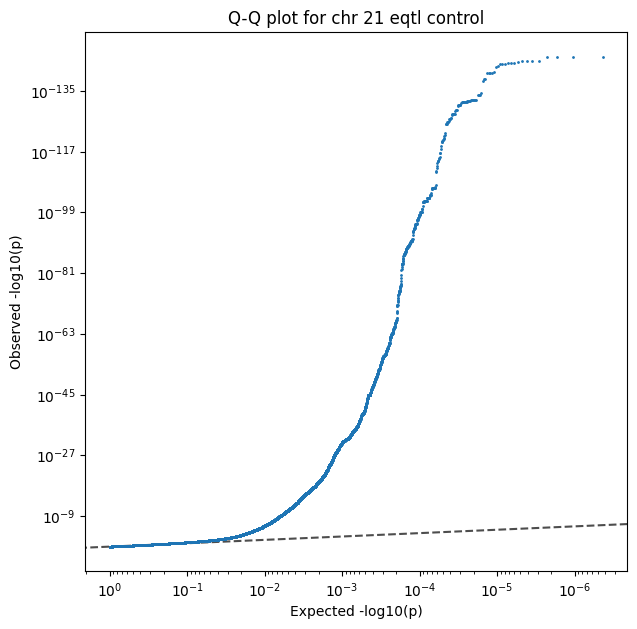

In [74]:
# q-q plot for p value inflation
f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale="log", xscale="log")
stats.probplot(pairs_df['pval_nominal'], dist="uniform", plot=ax)
ax.invert_xaxis()
ax.invert_yaxis()

# change the line colors and styles
ax.get_lines()[1].set_marker('o')
ax.get_lines()[1].set_markersize(1.0)
ax.get_lines()[1].set_markeredgecolor(sns.color_palette()[0])
ax.get_lines()[2].set_linewidth(0)

ax.set_xlabel('Expected -log10(p)')
ax.set_ylabel('Observed -log10(p)')
ax.set_title('Q-Q plot for chr 21 eqtl control')
plt.show()

### Plots for individual genes

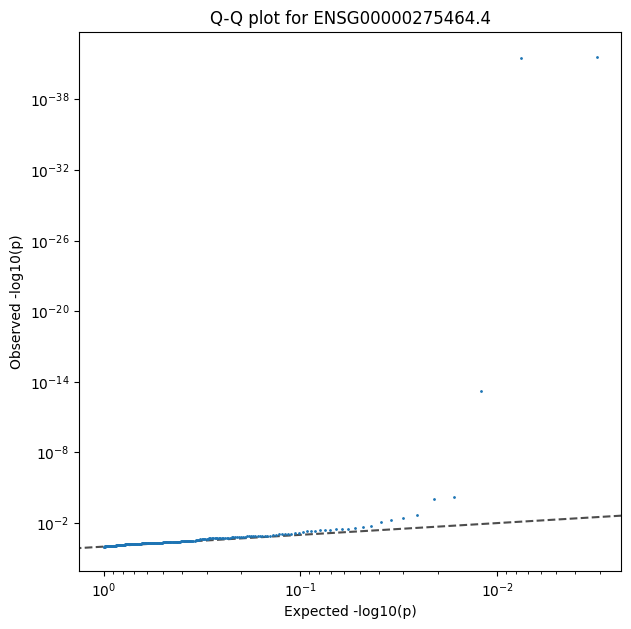

In [78]:
# q-q plot for p value inflation for just one gene
i=2

f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")

ax.set(yscale="log", xscale="log")
sub_df=pairs_df[pairs_df['phenotype_id']==pairs_df['phenotype_id'].unique()[i]]
stats.probplot(sub_df['pval_nominal'], dist="uniform", plot=ax)
ax.invert_xaxis()
ax.invert_yaxis()

# change the line colors and styles
ax.get_lines()[1].set_marker('o')
ax.get_lines()[1].set_markersize(1.0)
ax.get_lines()[1].set_markeredgecolor(sns.color_palette()[0])
ax.get_lines()[2].set_linewidth(0)

ax.set_xlabel('Expected -log10(p)')
ax.set_ylabel('Observed -log10(p)')
ax.set_title('Q-Q plot for {}'.format(pairs_df['phenotype_id'].unique()[i]))
plt.show()

Text(0.5, 1.0, 'variant associations for ENSG00000280433.1')

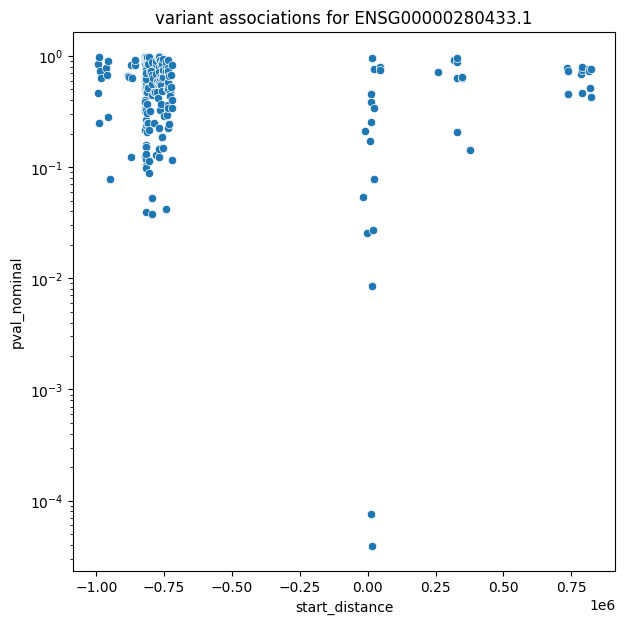

In [40]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
i=3
sns.scatterplot(pairs_df[pairs_df['phenotype_id']==pairs_df['phenotype_id'].unique()[i]], x='start_distance', y='pval_nominal', ax=ax)
ax.set_title('variant associations for {}'.format(pairs_df['phenotype_id'].unique()[i]))

Text(0.5, 1.0, 'variant associations for ENSG00000275993.2')

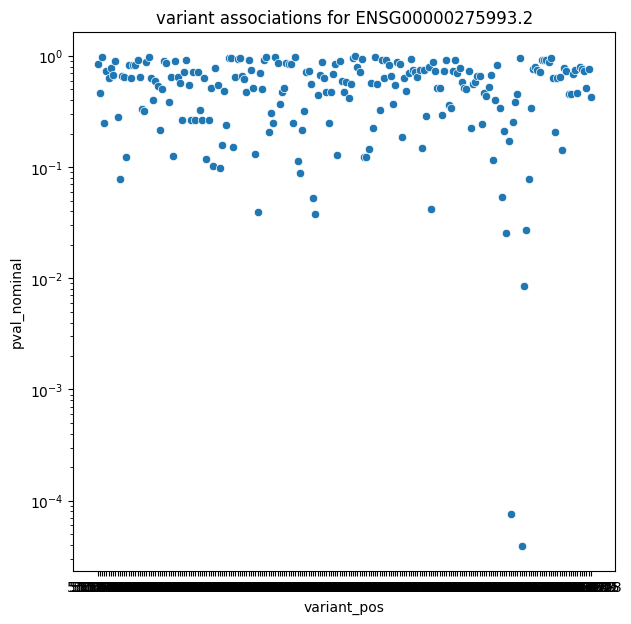

In [44]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
i=4
sns.scatterplot(pairs_df[pairs_df['phenotype_id']==pairs_df['phenotype_id'].unique()[i]], x='variant_pos', y='pval_nominal', ax=ax)
ax.set_title('variant associations for {}'.format(pairs_df['phenotype_id'].unique()[i]))

<Axes: xlabel='variant_pos', ylabel='start_distance'>

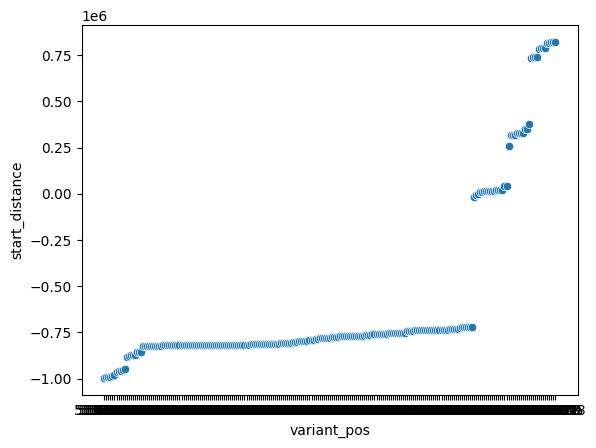

In [49]:
sns.scatterplot(pairs_df[pairs_df['phenotype_id']==pairs_df['phenotype_id'].unique()[4]], x='variant_pos', y='start_distance')


### varying sample size
one of the figures is the num eqtl vs sample size for pcs compared to standard single gene

In [80]:
# get the number of independnet eqtls
indep_df = cis.map_independent(genotype_df, variant_df, cis_df,
                               phenotype_df, phenotype_pos_df, covariates_df)

cis-QTL mapping: conditionally independent variants
  * 670 samples
  * 149/214 significant phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000


  * checking phenotypes: 149/149
  * computing independent QTLs
    processing phenotype 149/149
  Time elapsed: 8.75 min
done.


In [82]:
indep_df.to_csv('/home/klawren/oak/coexp_eqtl/output/2_eqtl_control/Whole_Blood/Whole_Blood.all_genes.indep_qtl.chr21.txt')

In [86]:
indep_df.shape

(321, 18)

In [97]:
num_samples = phenotype_df.shape[1]
sub_samples = np.asarray([.1, .3, .5, 1]) * num_samples
sub_samples

array([ 67., 201., 335., 670.])

In [113]:
# change the sample sizes and run a loop

# load in a subset of the data, indexed by sample id
sub_ids = pd.Series(phenotype_df.columns.values).sample(100, random_state=26).values

# phenotype_df and genotype_df both have to be subsampled
# do the covariates need to be recalcuated??
# phenotype_pos_df, variant_df just have indexing information and can stay the same

# run the permutation step
sub_cis_df = cis.map_cis(genotype_df[sub_ids], variant_df, 
                    phenotype_df.loc[phenotype_pos_df['chr'] == 'chr21'][sub_ids], 
                    phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr21'],
                    covariates_df=covariates_df.loc[sub_ids], seed=3042235018, warn_monomorphic=False)

# compute q-value (in practice, this must be run on all genes, not a subset)
# is this necessary to do?
tensorqtl.calculate_qvalues(sub_cis_df, qvalue_lambda=0.85)

sub_indep_df = cis.map_independent(genotype_df[sub_ids], variant_df, sub_cis_df,
                               phenotype_df[sub_ids], phenotype_pos_df, covariates_df.loc[sub_ids])



cis-QTL mapping: empirical p-values for phenotypes
  * 100 samples
  * 214 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * using seed 3042235018
  * checking phenotypes: 214/214
  * computing permutations
    processing phenotype 214/214
  Time elapsed: 1.32 min
done.
Computing q-values
  * Number of phenotypes tested: 214
  * Correlation between Beta-approximated and empirical p-values: 0.9999
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.31
  * QTL phenotypes @ FDR 0.05: 12
  * min p-value threshold @ FDR 0.05: 0.00504157
cis-QTL mapping: conditionally independent variants
  * 100 samples
  * 12/214 significant phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 12/12
  * computing independent QTLs
    processing phenotype 12/12
  Time elapsed: 0.10 min
done.


In [114]:
sub_indep_df.shape

(12, 18)